In [1]:
import lib_lamune as lmn
lmn.reload(lmn)

<module 'lib_lamune' from 'd:\\#Desktop\\Git\\Github\\Lamune_Util\\lib_lamune.py'>

In [2]:
# # 그래프 한글 출력 깨짐 해결
# import matplotlib.font_manager
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# [f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]
# [f.name for f in matplotlib.font_manager.fontManager.ttflist if 'D2' in f.name]

# plt.style.use('ggplot')
# font = {'size': 12,
#         #'family': 'NanumBarunGothic'}
#         'family': 'Malgun Gothic'}
# mpl.rc('font', **font)

In [3]:
# data loading 
import parquet
import pandas as pd 

path_save = "../PRJ_02/data_save/"
fileName = "01_Data_합친것.parquet"
df_all_data = pd.read_parquet(f"{path_save}/{fileName}", engine='pyarrow') 

fileName = "01_target.parquet"
df_target_all = pd.read_parquet(f"{path_save}/{fileName}", engine='pyarrow') 


In [4]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df_all_data, minimal=True)
# profile

In [5]:
# 데이터 전처리
# df_x_clean = df_all_data.fillna(0)
# # df_target_all = df_target_all.fillna(0)
df_x_clean = df_all_data
df_y_clean = df_target_all['미래환율_증가여부']

# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# df_y_clean = le.fit_transform(df_y_clean)

In [6]:
# data split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( df_x_clean ,df_y_clean  , test_size=0.2, random_state=42 , stratify=df_y_clean )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train , test_size=0.2, random_state=42  , stratify=y_train )

In [7]:
#평가 지표 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score , roc_auc_score , confusion_matrix

def get_clf_eval(y_test, y_pred=None, pred_proba=None):

    # print( "y_test = ", y_test.shape , y_test )
    # print( "y_pred = ", y_pred.shape , y_pred )
    # print( "pred_proba = ", pred_proba.shape , pred_proba )

    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, pred_proba)

    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [8]:
# 피쳐 중요도를 저장할 dict
dict_feautre_importances = {}

In [9]:
# 기준모델
base_major = pd.Series(y_test).mode()
print(f"base_major = {base_major}" )
y_pred_base = [base_major] * len(y_test)

print ( f'타겟값 비율=            \n{ y_test.value_counts(normalize=True) } ' )
print ( f'타겟 베이스라인 스코어 = { y_test.value_counts(normalize=True).max() } ' )

# 기준모델 성능 지료
from sklearn.metrics import roc_auc_score
get_clf_eval (y_test, y_pred=y_pred_base, pred_proba=y_pred_base)

base_major = 0    False
Name: 미래환율_증가여부, dtype: bool
타겟값 비율=            
False    0.876982
True     0.123018
Name: 미래환율_증가여부, dtype: float64 
타겟 베이스라인 스코어 = 0.8769819573537452 
오차행렬:
 [[1604    0]
 [ 225    0]]

정확도: 0.8770
정밀도: 0.0000
재현율: 0.0000
F1: 0.0000
AUC: 0.5000


In [10]:
# 모델 학습
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

#학습
lgbm_wrapper = LGBMClassifier(n_estimators=400)
evals = [(X_val, y_val)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=False)

# 테스트 셋 성능 확인
y_pred = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, y_pred, pred_proba)


오차행렬:
 [[1595    9]
 [  13  212]]

정확도: 0.9880
정밀도: 0.9593
재현율: 0.9422
F1: 0.9507
AUC: 0.9990


In [11]:
# 피쳐 중요도 표 
#    파일로 저장

dt_importance = pd.DataFrame()
dt_importance['Feature'] = X_test.columns # 설명변수 이름
dt_importance['Importance'] = lgbm_wrapper.feature_importances_ # 설명변수 중요도 산출

dt_importance.sort_values( by='Importance' , ascending= False, inplace=True)

# 파일로 저장
df_tmp = dt_importance
# path_save = "./data_save"
fileName = "02_feature_analy_xgbm_feature_importance.csv"
lmn.FILE_DataFrame_저장( df_tmp , path_save , fileName ,useParquet = False , useAutoFileName = True , index= True)

print( dt_importance )


# 피쳐 중요도 저장
dict_feautre_importances[ 'lgbm' ] = dt_importance

파일명 : ../PRJ_02/data_save//02_feature_analy_xgbm_feature_importance.csv_(2022_09_29__131847).csv 
                Feature  Importance
20           원유로_환율_원자료          37
324     원유로_환율_원자료_(10)          36
61              CMA_원자료          28
277   대외채무_단기_전년동기대비증감률          28
5            원달러_환율_원자료          25
..                  ...         ...
235  경제성장률_중국_전년동기대비증감률           0
236  경제성장률_중국_이동평균(3기간)           0
238     경제성장률_일본_전기대비증감           0
242  경제성장률_일본_이동평균(3기간)           0
448  Copper_Value_(240)           0

[449 rows x 2 columns]


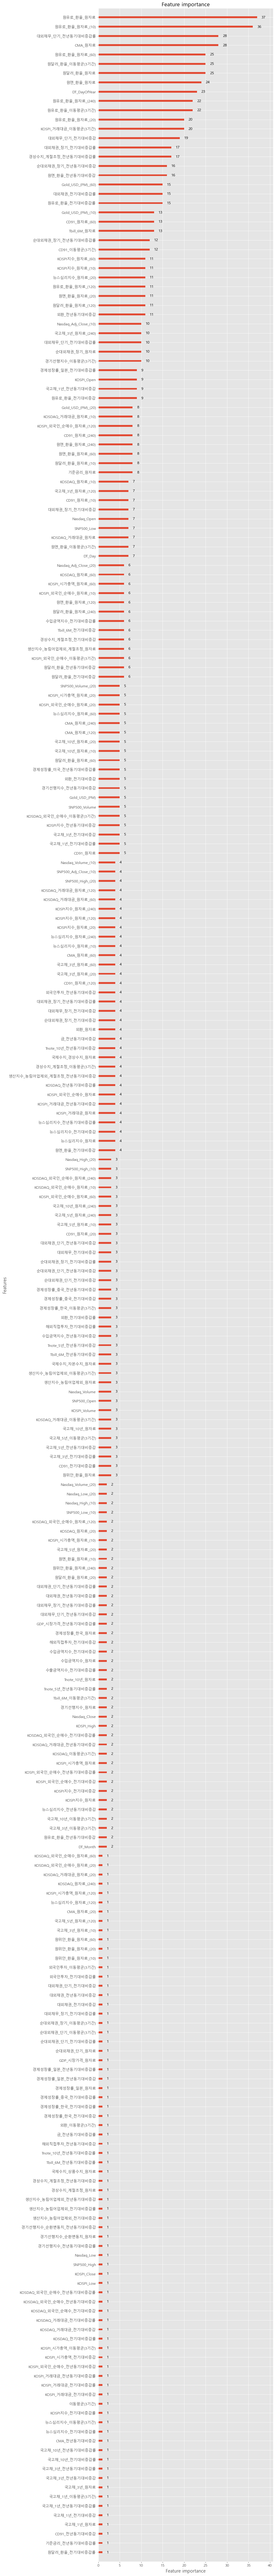

In [12]:
# 피쳐 중요도 그래프 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,150))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

In [20]:
X_train_encoded = X_train
X_val_encoded = X_val


# 모델 xgboost 
from xgboost import XGBClassifier

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
)
print(model)

watchlist = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

# 테스트 셋 성능 확인
y_pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]
get_clf_eval(y_test, y_pred, pred_proba)


선택Model = model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=987654321, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...)
[0]	validation_0-auc:0.93428	validation_1-auc:0.95994
[1]	validation_0-auc:0.93692	validation_1-auc:0.96828
[2]	validation_0-auc:0.93694	validation_1-auc:0.96842
[3]	validation_0-auc:0.93701	validation_1-auc:0.96860
[4]	validation_0-auc:0.96466	validation_1-au

In [14]:
#랜덤 포레스트 모델 학습

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
import numpy as np

# 파이프라인 
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(fill_value = 0 , strategy= 'constant' ), # missing_values=np.nan),
    # SimpleImputer(strategy = 'most_frequent' ), # mean , median 
    # SimpleImputer(missing_values=np.nan ),
    RandomForestClassifier(random_state=42,
                            # oob_score=True, 일반화 정확도를 줄이기 위해  (부트스트랩 샘플링 시 선택되지 않은 샘플oob)  샘플 사용 여부
                            # class_weight="balanced"
                            n_jobs=-1,
                            max_depth=3,   
                            )
    )
pipe.fit(X_train,y_train )


model = pipe
# 테스트 셋 성능 확인
y_pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]
get_clf_eval(y_test, y_pred, pred_proba)


오차행렬:
 [[1600    4]
 [  78  147]]

정확도: 0.9552
정밀도: 0.9735
재현율: 0.6533
F1: 0.7819
AUC: 0.9719


In [15]:
# 특성 중요도
from matplotlib.cbook import ls_mapper


model = pipe.named_steps["randomforestclassifier"]
importances = pd.Series(model.feature_importances_, X_train.columns)
importances = importances.sort_values(ascending= False)


# 리스트 출력 
print( importances.head(10) )


# 파일로 저장
df_tmp = importances
# path_save = "./data_save"
fileName = "02_feature_analy_RandomForest_feature_importance"
lmn.FILE_DataFrame_저장( df_tmp , path_save , fileName ,useParquet = False , useAutoFileName = True , index= True)

# 피쳐 중요도 저장
dict_feautre_importances[ 'rforest' ] = importances


기준금리_원자료              0.063207
대외채무_장기_전년동기대비증감률     0.043224
대외채권_단기_전기대비증감률       0.042809
기준금리_이동평균(3기간)        0.041718
대외채권_전기대비증감률          0.035383
순대외채권_단기_전년동기대비증감률    0.029408
대외채무_단기_전년동기대비증감률     0.027599
대외채무_단기_전년동기대비증감      0.021823
국고채_5년_이동평균(3기간)      0.020140
대외채무_단기_원자료           0.019706
dtype: float64
파일명 : ../PRJ_02/data_save//02_feature_analy_RandomForest_feature_importance_(2022_09_29__131906).csv 


In [16]:
# Decision Tree

from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(missing_values=np.nan ),
    # SimpleImputer(fill_value = 0 , strategy= 'constant' ), # missing_values=np.nan),
    DecisionTreeClassifier(random_state=2, criterion="entropy" 
                           ,max_depth=4 ),
)
pipe.fit(X_train, y_train)

model = pipe
# 테스트 셋 성능 확인
y_pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]
get_clf_eval(y_test, y_pred, pred_proba)

오차행렬:
 [[1591   13]
 [  30  195]]

정확도: 0.9765
정밀도: 0.9375
재현율: 0.8667
F1: 0.9007
AUC: 0.9915


In [17]:
# #TODO : 설치 문제가 있어서 동작하지 않음

# import graphviz
# from sklearn.tree import export_graphviz


# model_dt = pipe.named_steps['decisiontreeclassifier']
# lst_col_name = X_train.columns


# dot_data = export_graphviz(model_dt
#                           , max_depth=3
#                           , feature_names=lst_col_name
#                           , class_names=['no', 'yes']
#                           , filled=True
#                           , proportion=True)


# display(graphviz.Source(dot_data))

----

# 모델 분석

In [36]:
# 데이터셋(data), 분석할 데이터의 index(data_index), 변화를 확인할 특성명(target_feature), 바꿔넣어 볼 특성의 범위(target_feature_range)를 입력하면
# 해당 범위에서 모델의 예측 양상의 변화를 반환하는 함수를 작성합니다.
def get_ice_plot_data(df_tmp, data_index, target_feature, target_feature_range, model):
    one_datapoint = df_tmp.iloc[[data_index]].copy()
    results = []

    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred_proba = model.predict_proba(one_datapoint)[:, 1]
        results.append(one_datapoint_pred_proba.item())
    results = np.array(results)
    
    return target_feature_range, results - results[0]


In [45]:
model = 선택Model
lst_target_feature = ['DT_DayOfYear','원유로_환율_원자료','CMA_원자료','원달러_환율_원자료','원엔_환율_원자료','CD91_이동평균(3기간)','KOSPI_거래대금_이동평균(3기간)','KOSPI_Open','Tbill_6M_원자료','국고채_3년_원자료_(240)','뉴스심리지수_원자료_(20)','Nasdaq_Adj_Close_(10)','Gold_USD_(PM)_(60)','대외채무_단기_전년동기대비증감률','경기선행지수_이동평균(3기간)','외환_전년동기대비증감','순대외채권_장기_원자료','대외채무_단기_전기대비증감률','대외채권_장기_전기대비증감률' ]

# 분석 데이터 만들기
df_모델분석 = X_train 
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# df_모델분석['target'] = y_train
df_tmp = X_train

In [46]:
from numpy import arange
from tqdm import tqdm


def GRAPH_PDP그리기( df_tmp , target_feature ) :

    # 타겟 컬럼의 값의 범위 계산 ( TODO max 값을 포함 하도록 하려면 어떻게 해야 할까? )
    target_feature_range = target_feature_range = target_feature_range = arange(df_tmp[target_feature].min(), df_tmp[target_feature].max() )

    # 모든 검증 데이터에 대해 우리가 작성한 함수로 ICE plot 데이터를 계산합니다.
    all_ice_plot_data = []
    for data_index in tqdm(range(len(df_tmp))):
        all_ice_plot_data.append(
            get_ice_plot_data(df_tmp, data_index, target_feature, target_feature_range, model )[1]
        )
            
    # 시각화
    all_ice_plot_data = np.array(all_ice_plot_data)
    print(all_ice_plot_data.shape)

    # 6033개의 ICE plot data를 0번째(data index) 축으로 평균합시다.
    pdp_data = all_ice_plot_data.mean(0)
    print(pdp_data.shape)

    # PDP(평균 ICE plot) data를 시각화해 봅시다.
    fig, ax = plt.subplots(figsize=(8, 8)) # 크기
    ax.set_title(f"PDP-{target_feature}")   # 제목

    plt.plot(target_feature_range, pdp_data)
    plt.xlabel(target_feature)
    plt.ylabel("AVG ( $\Delta$ pred_proba ) ")
    plt.show()



for col_name in lst_target_feature :
    GRAPH_PDP그리기( df_tmp , col_name )

 11%|█         | 629/5852 [57:29<8:05:27,  5.58s/it]